# 赛事背景

品冠科技深耕智能家居多年，基于人工智能和大数据技术，智能家居系统更加智能化，用户的体验也大大提高。

公司智能家居业务发展需要，在全国各地设有不同等级的代理商。为了让用户切身感受到智能家居产品的智能化和便捷性，每个代理商均有自己的智能家居体验店和展厅。

# 赛事任务

根据公司的发展策略，需要让终端用户在智能家居体验过程中能够更加强烈、清晰的感受到智能家居系统的优点，系统会针对展厅类的场景做特殊的场景优化。为了实现这一场景下的优化，就需要系统能够准确、快速的分析出当前智能家居产品使用环境是真实的家庭还是智能化体验的公共区域。

# 评审规则
1.数据说明

本次比赛为参赛选手提供了4类数据：账号信息、设备列表、控制操作日志、设备上报日志。其中账号基础数据的训练集我们会打上使用场景是家庭用户还是体验厅的标签。

出于数据安全保证的考虑，所有数据均为脱敏处理后的数据。数据集会分为两个部分，第一部分数据有使用场景标签，用于识别算法训练，第二部分不包含场景标签，数据用于预测。

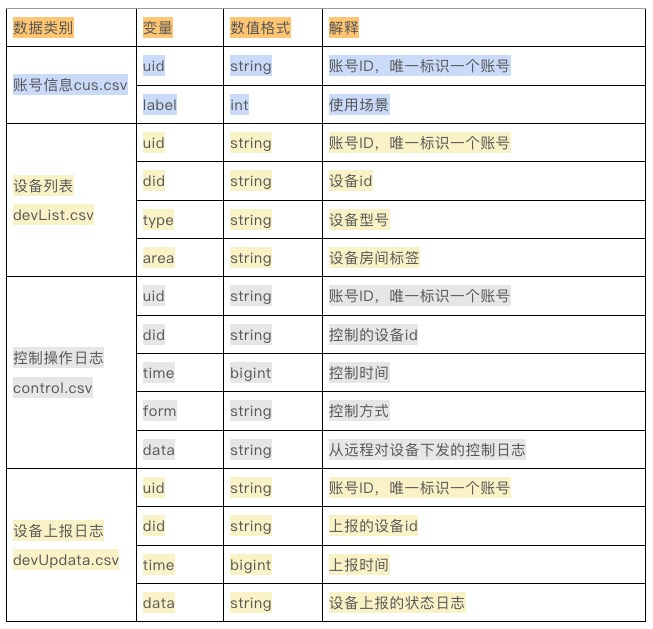

2.评估指标

本模型依据提交的结果文件，采用F1-score进行评价。

（1）统计TP（正确预测环境场景），FP（错将家庭场景预测为公共区域），FN（错将公共区域预测为家庭记录）

（2）通过第一步的统计值计算模型的precision和recall

（3）通过第二步计算结果计算F1-score,得到最后评测结果

# 读取数据

In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import codecs

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [86]:
def robust_readcsv(path, sep=','):
    try:
        lines = codecs.open(path).readlines()
    except:
        lines = codecs.open(path, encoding='latin-1').readlines()
    header = lines[0].strip().split(sep)
    content = []
    for line in lines[1:]:
        line = line.strip()
        try:
            index = [i for i, x in enumerate(line) if x == ',']
            if len(index) == len(header) - 1:
                content.append(line.split(sep))
            else:
                line_content = []
                index = [0] + index
                for idx in range(len(header)-1):
                    line_content.append(line[index[idx]:index[idx+1]].strip(sep))
                line_content.append(line[index[len(header)-1]:].strip(sep))
                content.append(line_content)
        except:
            pass
    
    return pd.DataFrame(content, columns=header)

train_cus = pd.read_csv('智能家居使用场景识别挑战赛数据集/训练集/cus.csv', sep=',')
test_cus = pd.read_csv('智能家居使用场景识别挑战赛数据集/测试集/cus.csv', sep=',')

train_devupdate = robust_readcsv('智能家居使用场景识别挑战赛数据集/训练集/devUpdata.csv', sep=',')
test_devupdate = robust_readcsv('智能家居使用场景识别挑战赛数据集/测试集/devUpdata.csv', sep=',')

train_control = robust_readcsv('智能家居使用场景识别挑战赛数据集/训练集/control.csv', sep=',')
test_control = robust_readcsv('智能家居使用场景识别挑战赛数据集/测试集/control.csv', sep=',')

train_devlist = robust_readcsv('智能家居使用场景识别挑战赛数据集/训练集/devList.csv', sep=',')
test_devlist = robust_readcsv('智能家居使用场景识别挑战赛数据集/测试集/devList.csv', sep=',')

In [87]:
train_cus.shape, test_cus.shape

((915, 2), (267, 1))

In [88]:
train_devupdate.shape, test_devupdate.shape

((346797, 4), (113574, 4))

In [89]:
train_control.shape, test_control.shape

((334006, 5), (112371, 5))

In [90]:
train_devlist.shape, test_devlist.shape

((8858, 4), (2501, 4))

# 数据分析

In [119]:
train_devupdate_feat = train_devupdate.groupby('uid').agg({
    'did': 'nunique',
    'data': 'nunique',
})
train_devupdate_feat.reset_index(inplace=True)
train_devupdate_feat.columns = ['uid', 'devupdate_did_count', 'devupdate_data_count']

test_devupdate_feat = test_devupdate.groupby('uid').agg({
    'did': 'nunique',
    'data': 'nunique',
})
test_devupdate_feat.reset_index(inplace=True)
test_devupdate_feat.columns = ['uid', 'devupdate_did_count', 'devupdate_data_count']

In [120]:
train_control_feat = train_control.groupby('uid').agg({
    'did': 'nunique',
    'form': 'nunique',
    'data': 'nunique',
})
train_control_feat.reset_index(inplace=True)
train_control_feat.columns = ['uid', 'devcontrol_did_count', 
                              'devcontrol_form_count', 'devcontrol_data_count']

test_control_feat = test_control.groupby('uid').agg({
    'did': 'nunique',
    'form': 'nunique',
    'data': 'nunique',
})
test_control_feat.reset_index(inplace=True)
test_control_feat.columns = ['uid', 'devcontrol_did_count', 
                              'devcontrol_form_count', 'devcontrol_data_count']

In [149]:
train_devlist_feat = train_devlist.groupby('uid').agg({
    'did': 'nunique',
    'type': 'nunique',
    'area': ['unique', 'nunique', 'count']
})
train_devlist_feat.reset_index(inplace=True)
train_devlist_feat.columns = [x[0] + x[1] for x in train_devlist_feat.columns]

test_devlist_feat = test_devlist.groupby('uid').agg({
    'did': 'nunique',
    'type': 'nunique',
    'area': ['unique', 'nunique', 'count']
})
test_devlist_feat.reset_index(inplace=True)
test_devlist_feat.columns = [x[0] + x[1] for x in test_devlist_feat.columns]

In [174]:
train_feat = train_cus.merge(train_devlist_feat, on='uid')
train_feat = train_feat.merge(train_control_feat, on='uid', how='left')
train_feat = train_feat.merge(train_devupdate_feat, on='uid', how='left')
train_feat.fillna(0, inplace=True)

In [175]:
test_feat = test_cus.merge(test_devlist_feat, on='uid')
test_feat = test_feat.merge(test_control_feat, on='uid', how='left')
test_feat = test_feat.merge(test_devupdate_feat, on='uid', how='left')
test_feat.fillna(0, inplace=True)

In [176]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=400)
train_dev_tfidf = tfidf.fit_transform(train_feat['areaunique'].apply(lambda x: ' '.join(x)))
test_dev_tfidf = tfidf.transform(test_feat['areaunique'].apply(lambda x: ' '.join(x)))

In [177]:
train_dev_tfidf = pd.DataFrame(train_dev_tfidf.toarray(), columns=tfidf.get_feature_names())
test_dev_tfidf = pd.DataFrame(test_dev_tfidf.toarray(), columns=tfidf.get_feature_names())

In [178]:
train_feat = pd.concat([train_dev_tfidf, train_feat], axis=1)
test_feat = pd.concat([test_dev_tfidf, test_feat], axis=1)

In [179]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [193]:
clf = RandomForestClassifier()
clf.fit(train_feat.drop(['uid', 'label', 'areaunique'], axis=1), train_feat['label'])
test_cus['label'] = clf.predict(test_feat.drop(['uid','areaunique'], axis=1),)

In [194]:
test_cus.to_csv('rf_submit.csv', index=None)

In [195]:
test_cus['label'].value_counts()

0    249
1     18
Name: label, dtype: int64